## QEM Applications

In [2]:
import tensorcircuit as tc
from tensorcircuit.results import qem
from tensorcircuit.results.qem import qem_methods, benchmark_circuits
from tensorcircuit.results.qem import zne_option,apply_zne,dd_option,apply_dd,apply_rc

from tensorcircuit.cloud import apis
from tensorcircuit.results import counts
from tensorcircuit.results.readout_mitigation import ReadoutMit
from tensorcircuit.compiler.qiskit_compiler import qiskit_compile

from functools import partial
import numpy as np
import networkx as nx

### ZNE

In [3]:
d = apis.get_device("tianxuan_s1")
couple_list = d.topology()
print(couple_list)

[[0, 1], [6, 2], [4, 0], [0, 4], [8, 4], [1, 5], [3, 7], [0, 3], [2, 0], [5, 1], [3, 0], [7, 3], [0, 2], [2, 6], [4, 8], [1, 0]]


In [4]:
mit = tc.results.rem.ReadoutMit("tianxuan_s1?o=0")   # set ?o=0 for readout mitigation initialization 
mit.cals_from_system(qubits=9, shots=4096)

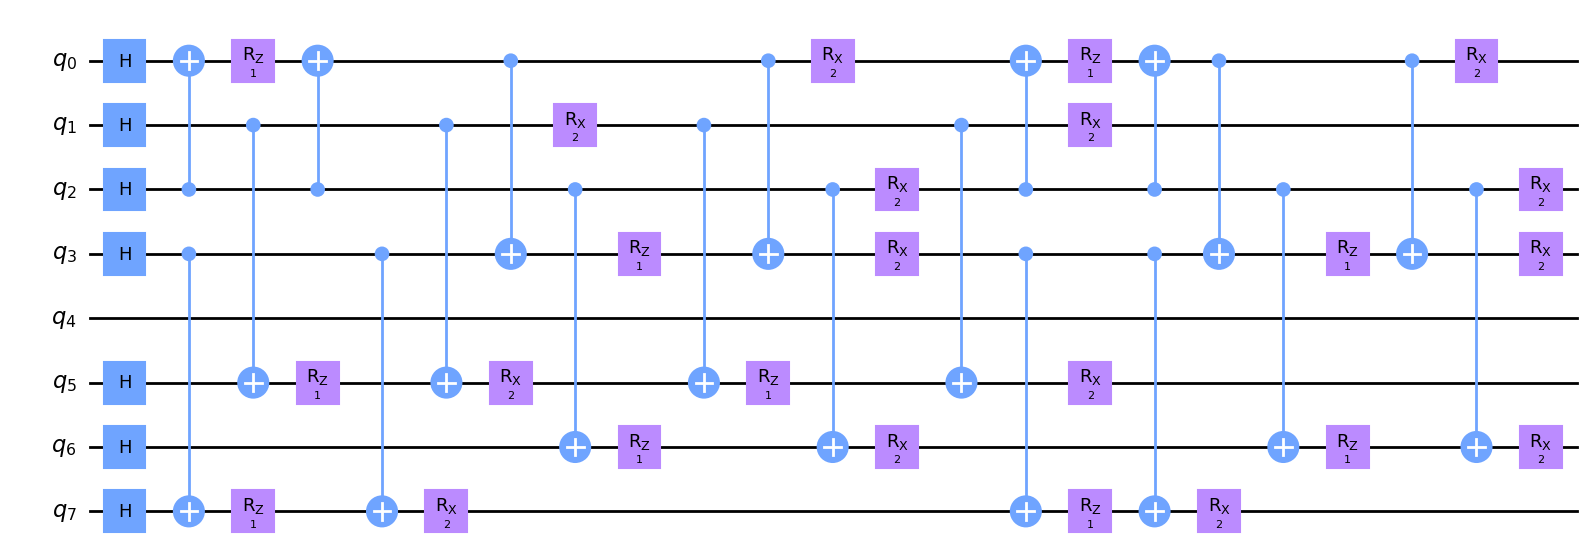

In [5]:
graph = [(2,0),(3,7),(0,3),(1,5),(2,6)]
weight = [1]*len(graph)
params = np.array([[1,1],[1,1]])
optimization_level=2


c = benchmark_circuits.QAOA_circuit(graph, weight, params)
c.to_qiskit().draw("mpl")   

In [31]:
c1, info = qiskit_compile(
    c,
    compiled_options={
        "basis_gates": ['h', 'rz', 'x', 'y', 'z', 'cz'],
        "optimization_level": optimization_level,
        # "coupling_map": d.topology(),
    },
)

In [32]:
t = apis.submit_task(circuit=c, shots=10000, device="simulator:aer")
raw_count = t.results(blocked=True)
ideal = sum([-counts.expectation(raw_count, z=[graph[e][0], graph[e][1]])*weight[e] for e in range(len(graph))])
print("ideal",ideal)

t = apis.submit_task(circuit=c1,shots=10000,device=d,enable_qos_qubit_mapping=False,enable_qos_gate_decomposition=False)
raw_count = t.results(blocked=True)
raw = sum([-counts.expectation(raw_count, z=[graph[e][0], graph[e][1]])*weight[e] for e in range(len(graph))])
print("raw",raw)
read = sum([-mit.expectation(raw_count, z=[graph[e][0], graph[e][1]],**info)*weight[e] for e in range(len(graph))])
print("read",read)

ideal 0.9400000000000001
raw 0.37379999999999997
read 0.4909275773352902


zne 0.6603988839789069


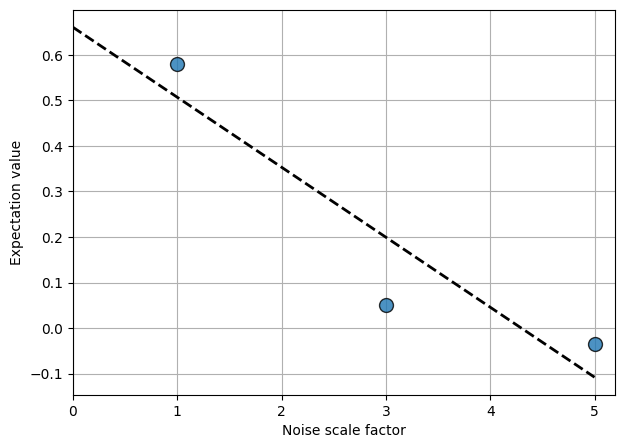

In [33]:

def execute(circuit):
    t = apis.submit_task(circuit=circuit, shots=10000, device=d,enable_qos_qubit_mapping=False,enable_qos_gate_decomposition=False)
    count =t.results(blocked=True)
    a = sum([-mit.expectation(count, z=[graph[e][0], graph[e][1]],**info)*weight[e] for e in range(len(graph))])
    # a = sum([-counts.expectation(raw_count, z=[graph[e][0], graph[e][1]])*w[e] for e in range(len(graph))])
    return a

random_state = np.random.RandomState(0)
noise_scaling_function = partial(
    zne_option.scaling.fold_gates_at_random,
    fidelities = {"single": 1.0},  
    random_state=random_state, 
)
factory = zne_option.inference.PolyFactory (scale_factors=[1,3,5],order = 1)
# factory = zne_option.inference.ExpFactory(scale_factors=[1,1.5,2],asymptote=0.)
# factory = zne_option.inference.RichardsonFactory(scale_factors=[1,1.5,2])
# factory = zne_option.inference.AdaExpFactory(steps=5, asymptote=0.)

result = apply_zne(
    circuit=c1, executor = execute, factory=factory, scale_noise = noise_scaling_function,num_to_average=1
)
_ = factory.plot_fit()
print("zne",result)

### DD

In [35]:
d = apis.get_device("tianshu_s1")
couple_list = d.topology()
print(couple_list)

[[18, 17], [7, 17], [3, 4], [14, 4], [4, 3], [5, 4], [16, 17], [12, 13], [14, 13], [3, 13], [8, 9], [10, 0], [9, 8], [19, 9], [1, 0], [19, 18], [17, 18], [8, 18], [13, 14], [15, 5], [6, 5], [15, 14], [18, 19], [4, 5], [5, 6], [18, 8], [4, 14], [14, 15], [0, 1], [11, 1], [5, 15], [1, 2], [10, 11], [2, 1], [11, 10], [0, 10], [1, 11], [9, 19], [16, 6], [6, 7], [15, 16], [7, 6], [16, 15], [12, 2], [6, 16], [3, 2], [12, 11], [17, 7], [8, 7], [17, 16], [2, 3], [11, 12], [13, 3], [2, 12], [13, 12], [7, 8]]


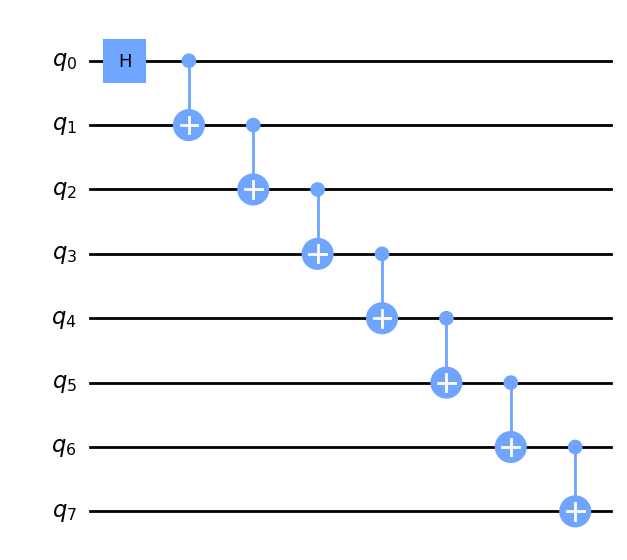

In [37]:
c, ideal = benchmark_circuits.ghz_circuit(8)
c.to_qiskit().draw("mpl") # logical circuit

In [38]:

c1, info = qiskit_compile(     
    c,
    compiled_options={
        "basis_gates": ['h', 'rz', 'x', 'y', 'z', 'cz'],
        "optimization_level": 2,
        # "coupling_map": d.topology(),   
    },
)

print(info)


{'logical_physical_mapping': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}, 'positional_logical_mapping': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}}


In [40]:
zpauli = [0,6] # logical

t = apis.submit_task(circuit=c, shots=10000, device="simulator:aer")
raw_count = t.results(blocked=True)
ideal = counts.expectation(raw_count, z=zpauli)
print("ideal",ideal)


t = apis.submit_task(circuit=c1,shots=10000,device=d,enable_qos_qubit_mapping=False,enable_qos_gate_decomposition=False)
raw_count = t.results(blocked=True)  # position_counts=logical_counts
raw = counts.expectation(raw_count, z=zpauli)
print("raw",raw)

ideal 1.0
raw 0.156


mit 0.1734


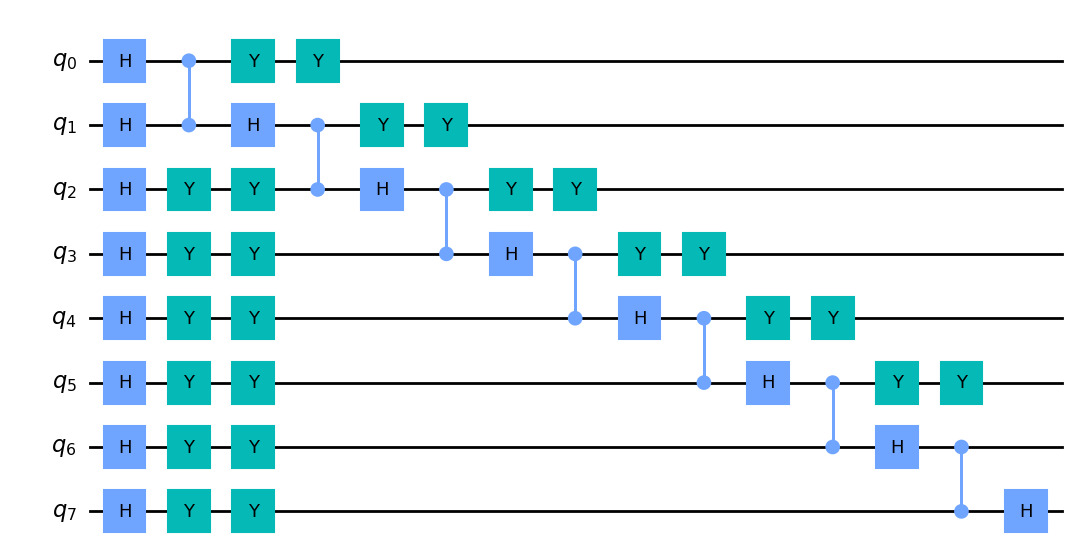

In [45]:
def execute(circuit):
    t = apis.submit_task(circuit=circuit, shots=10000, device=d,enable_qos_qubit_mapping=False,enable_qos_gate_decomposition=False)
    count =t.results(blocked=True)  # physical_counts

    n = len(info['logical_physical_mapping'])
    physical_qubits = [info['logical_physical_mapping'][i] for i in range(n)]
    count = counts.marginal_count(count,physical_qubits)
  
    # a = mit.expectation(count, z=zpauli,**info)
    a = counts.expectation(count, z=zpauli)
    return a


mitigated_result = apply_dd(
        circuit=c1, 
        executor=execute, 
        rule = dd_option.rules.yy,
        rule_args = {"spacing": -1},
        full_output = True,
        ignore_idle_qubit =True,
        fulldd = False
    )

print("mit",mitigated_result[0])
mitigated_result[1].to_qiskit().draw("mpl")

### RC

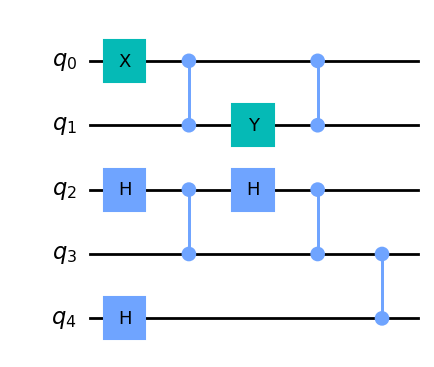

In [48]:
c = tc.Circuit(5)
c.x(0)
c.h(2)
c.cz(0,1)
c.cz(2,3)
c.y(1)
c.h(2)
c.cz(0,1)
c.cz(2,3)
c.h(4)
c.cz(3,4)

c.to_qiskit().draw("mpl")

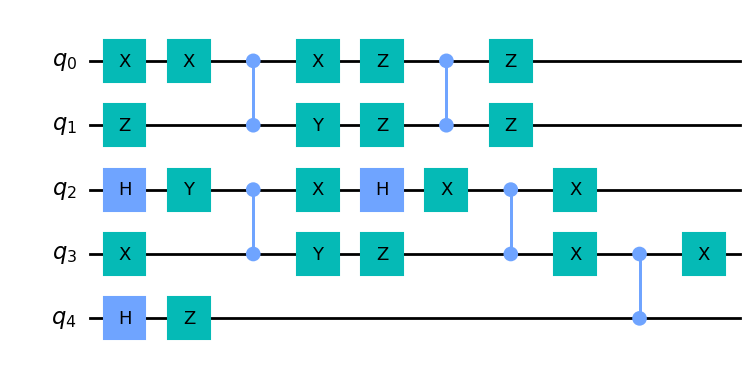

In [50]:
circuit = qem.rc_circuit(c)
circuit = qem.washcircuit(circuit,qlist=list(range(circuit.circuit_param["nqubits"])))
circuit.to_qiskit().draw("mpl")

{'logical_physical_mapping': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}, 'positional_logical_mapping': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}}


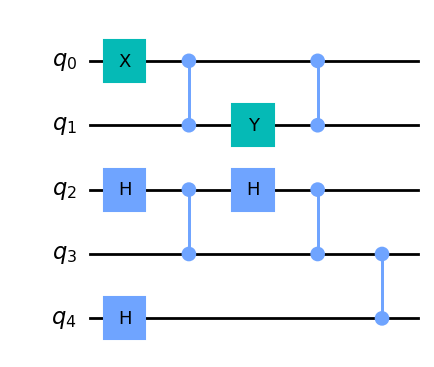

In [54]:
c1, info = qiskit_compile(     
    c,
    compiled_options={
        "basis_gates": ['h', 'rz', 'x', 'y', 'z','cz'],
        "optimization_level": 2,
        # "coupling_map": d.topology(),   
    },
)

print(info)
c1.to_qiskit().draw("mpl")  

In [57]:
zpauli = [1,2] # logical

t = apis.submit_task(circuit=c, shots=10000, device="simulator:aer")
raw_count = t.results(blocked=True)
ideal = counts.expectation(raw_count, z=zpauli)
print("ideal",ideal)


t = apis.submit_task(circuit=c1,shots=10000,device=d,enable_qos_qubit_mapping=False,enable_qos_gate_decomposition=False)
raw_count = t.results(blocked=True)  # position_counts=logical_counts
raw = counts.expectation(raw_count, z=zpauli)
print("raw",raw)


ideal -1.0
raw -0.3894


In [58]:

def execute(circuit):
    t = apis.submit_task(circuit=circuit, shots=10000, device=d,enable_qos_qubit_mapping=False,enable_qos_gate_decomposition=False)
    count =t.results(blocked=True)  # physical_counts

    n = len(info['logical_physical_mapping'])
    physical_qubits = [info['logical_physical_mapping'][i] for i in range(n)]
    count = counts.marginal_count(count,physical_qubits)
  
    # a = mit.expectation(count, z=zpauli,**info)
    a = counts.expectation(count, z=zpauli)
    return a


mitigated_result = apply_rc(
        circuit=c1, 
        executor=execute, 
        num_to_average=6,
        simplify=True
    )

print("mit",mitigated_result[0])


mitigated_result = apply_rc(
        circuit=c1, 
        executor=execute, 
        num_to_average=6,
        simplify=False
    )

print("mit",mitigated_result[0])

mit -0.39233333333333337
mit -0.4132
